<a href="https://colab.research.google.com/github/HilmyJamil/GETget/blob/sharing/Playlist_SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data Collection**

In [1]:
from googleapiclient.discovery import build
import pandas as pd
from google.colab import files, drive
import getpass

In [2]:
api_key = getpass.getpass('Please enter your YouTube API key: ')
playlist_ids = ['PLxUNmyJ_IIGx0FIn36DOX6NTO-eGDGVv9']

Please enter your YouTube API key: ··········


In [3]:
# Build the YouTube client
youtube = build('youtube', 'v3', developerKey=api_key)

Get Video IDs

In [4]:
def get_all_video_ids_from_playlists(youtube, playlist_ids):
    all_videos = []  # Initialize a single list to hold all video IDs

    for playlist_id in playlist_ids:
        next_page_token = None

        # Fetch videos from the current playlist
        while True:
            playlist_request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId=playlist_id,
                maxResults=50,
                pageToken=next_page_token)
            playlist_response = playlist_request.execute()

            all_videos += [item['contentDetails']['videoId'] for item in playlist_response['items']]

            next_page_token = playlist_response.get('nextPageToken')

            if next_page_token is None:
                break

    return all_videos

# Fetch all video IDs from the specified playlists
video_ids = get_all_video_ids_from_playlists(youtube, playlist_ids)

# Now you can pass video_ids to the next function
# next_function(video_ids)

Get all comments

In [5]:
# Function to get replies for a specific comment
def get_replies(youtube, parent_id, video_id):  # Added video_id as an argument
    replies = []
    next_page_token = None

    while True:
        reply_request = youtube.comments().list(
            part="snippet",
            parentId=parent_id,
            textFormat="plainText",
            maxResults=100,
            pageToken=next_page_token
        )
        reply_response = reply_request.execute()

        for item in reply_response['items']:
            comment = item['snippet']
            replies.append({
                'Timestamp': comment['publishedAt'],
                'Username': comment['authorDisplayName'],
                'VideoID': video_id,
                'Comment': comment['textDisplay'],
                'Date': comment['updatedAt'] if 'updatedAt' in comment else comment['publishedAt']
            })

        next_page_token = reply_response.get('nextPageToken')
        if not next_page_token:
            break

    return replies

# Function to get all comments (including replies) for a single video
def get_comments_for_video(youtube, video_id):
    all_comments = []
    next_page_token = None

    while True:
        comment_request = youtube.commentThreads().list(
            part="snippet",
            videoId=video_id,
            pageToken=next_page_token,
            textFormat="plainText",
            maxResults=100
        )
        comment_response = comment_request.execute()

        for item in comment_response['items']:
            top_comment = item['snippet']['topLevelComment']['snippet']
            all_comments.append({
                'Timestamp': top_comment['publishedAt'],
                'Username': top_comment['authorDisplayName'],
                'VideoID': video_id,  # Directly using video_id from function parameter
                'Comment': top_comment['textDisplay'],
                'Date': top_comment['updatedAt'] if 'updatedAt' in top_comment else top_comment['publishedAt']
            })

            # Fetch replies if there are any
            if item['snippet']['totalReplyCount'] > 0:
                all_comments.extend(get_replies(youtube, item['snippet']['topLevelComment']['id'], video_id))

        next_page_token = comment_response.get('nextPageToken')
        if not next_page_token:
            break

    return all_comments

# List to hold all comments from all videos
all_comments = []


for video_id in video_ids:
    video_comments = get_comments_for_video(youtube, video_id)
    all_comments.extend(video_comments)

# Create DataFrame
comments_df = pd.DataFrame(all_comments)

In [6]:
# Export whole dataset to the local machine as CSV File
csv_file = 'comments_data.csv'  # Name your file
comments_df.to_csv(csv_file, index=False)

from google.colab import files

# Trigger a download to your local machine
files.download(csv_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
comments_df.head()

,Timestamp,Username,VideoID,Comment,Date
0,2024-03-15T17:27:49Z,@robinfla52,PFx2t67Rh68,"To be honest, I don't get this one. But I do l...",2024-03-15T17:27:49Z
1,2024-03-14T08:37:29Z,@p00pnigga,PFx2t67Rh68,GUYS PLEASE WHATS THE GIRL WITH ORANGE JUMPER ...,2024-03-14T08:37:29Z
2,2024-03-14T03:19:27Z,@user-dh3df1gl5j,PFx2t67Rh68,Names?,2024-03-14T03:19:27Z
3,2024-03-12T13:22:03Z,@deundriadowns4336,PFx2t67Rh68,Who's here to figure out what she tossed in th...,2024-03-12T13:22:03Z
4,2024-03-11T23:57:46Z,@pablosorto7012,PFx2t67Rh68,Probably the most annoying commerical ever,2024-03-11T23:57:46Z


In [9]:
comments_df.shape

(545, 5)

In [10]:
comments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Timestamp  545 non-null    object
 1   Username   545 non-null    object
 2   VideoID    545 non-null    object
 3   Comment    545 non-null    object
 4   Date       545 non-null    object
dtypes: object(5)
memory usage: 21.4+ KB


**Data Labelling**

In [12]:
#Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os

# Import functions for data preprocessing & data preparation
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import string
from string import punctuation
import nltk
import re

Drop unnecessary data, we only going to be using "Comment" from comments_df

In [14]:
df1 = comments_df.drop(["Timestamp", "Username", "VideoID", "Date"], axis=1)

df1.head(10)

,Comment
0,"To be honest, I don't get this one. But I do l..."
1,GUYS PLEASE WHATS THE GIRL WITH ORANGE JUMPER ...
2,Names?
3,Who's here to figure out what she tossed in th...
4,Probably the most annoying commerical ever
5,I love this commercial.The look she gives the ...
6,Sleeping
7,Please stop. Please.
8,That's not real baby that probably a robot bab...
9,Can somebody anybody please explain this comme...


Here, we're going to be utilizing VADER rule-based lexicon to sort the comments into positive, negative, and neutral sentiment.

In [16]:
nltk.download('vader_lexicon')
sentiments = SentimentIntensityAnalyzer()

df1["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in df1["Comment"]]
df1["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in df1["Comment"]]
df1["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in df1["Comment"]]
df1['Compound'] = [sentiments.polarity_scores(i)["compound"] for i in df1["Comment"]]

score = df1["Compound"].values

sentiment = []

for i in score:
    if i >= 0.05 :
        sentiment.append('Positive')
    elif i <= -0.05 :
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')

df1["Sentiment"] = sentiment

df1.head(10)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Comment,Positive,Negative,Neutral,Compound,Sentiment
0,"To be honest, I don't get this one. But I do l...",0.174,0.277,0.549,-0.6357,Negative
1,GUYS PLEASE WHATS THE GIRL WITH ORANGE JUMPER ...,0.290,0.000,0.710,0.5040,Positive
2,Names?,0.000,0.000,1.000,0.0000,Neutral
3,Who's here to figure out what she tossed in th...,0.000,0.000,1.000,0.0000,Neutral
4,Probably the most annoying commerical ever,0.000,0.374,0.626,-0.4576,Negative
5,I love this commercial.The look she gives the ...,0.296,0.000,0.704,0.6369,Positive
6,Sleeping,0.000,0.000,1.000,0.0000,Neutral
7,Please stop. Please.,0.676,0.324,0.000,0.3400,Positive
8,That's not real baby that probably a robot bab...,0.000,0.114,0.886,-0.4019,Negative
9,Can somebody anybody please explain this comme...,0.223,0.000,0.777,0.3182,Positive


In [18]:
df2=df1.drop(['Positive', 'Negative', 'Neutral', 'Compound'], axis=1)
df2.head(10)

,Comment,Sentiment
0,"To be honest, I don't get this one. But I do l...",Negative
1,GUYS PLEASE WHATS THE GIRL WITH ORANGE JUMPER ...,Positive
2,Names?,Neutral
3,Who's here to figure out what she tossed in th...,Neutral
4,Probably the most annoying commerical ever,Negative
5,I love this commercial.The look she gives the ...,Positive
6,Sleeping,Neutral
7,Please stop. Please.,Positive
8,That's not real baby that probably a robot bab...,Negative
9,Can somebody anybody please explain this comme...,Positive


This will be the final data to be used in the next step.

**Data Transformation**

In this step, we are going to connvert the data into something that can be used by machine learning.

In [21]:
!pip install nltk

In [22]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [23]:
stop_words = stopwords.words('english')
porter_stemmer = PorterStemmer()
lancaster_stemmer = LancasterStemmer()
snowball_stemer = SnowballStemmer(language="english")
lzr = WordNetLemmatizer()

In [26]:
def text_processing(Comment):
    # convert text into lowercase
    Comment = Comment.lower()

    # remove new line characters in text
    Comment = re.sub(r'\n',' ', Comment)

    # remove punctuations from text
    Comment = re.sub('[%s]' % re.escape(punctuation), "", Comment)

    # remove references and hashtags from text
    Comment = re.sub("^a-zA-Z0-9$,.", "", Comment)

    # remove multiple spaces from text
    Comment = re.sub(r'\s+', ' ', Comment, flags=re.I)

    # remove special characters from text
    Comment = re.sub(r'\W', ' ', Comment)

    Comment = ' '.join([word for word in word_tokenize(Comment) if word not in stop_words])

    # stemming using porter stemmer from nltk package - msh a7sn 7aga - momken: lancaster, snowball
    # text=' '.join([porter_stemmer.stem(word) for word in word_tokenize(text)])
    # text=' '.join([lancaster_stemmer.stem(word) for word in word_tokenize(text)])
    # text=' '.join([snowball_stemer.stem(word) for word in word_tokenize(text)])

    # lemmatizer using WordNetLemmatizer from nltk package
    Comment=' '.join([lzr.lemmatize(word) for word in word_tokenize(Comment)])

    return Comment

In [29]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [31]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [32]:
nltk.download('omw-1.4')
df_copy = df2.copy()
df_copy.Comment = df_copy.Comment.apply(lambda Comment: text_processing(Comment))

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [33]:
le = LabelEncoder()

df_copy['Sentiment'] = le.fit_transform(df_copy['Sentiment'])

In [34]:
processed_data = {
    'Sentence':df_copy.Comment,
    'Sentiment':df_copy['Sentiment']
}

processed_data = pd.DataFrame(processed_data)
processed_data.head()

,Sentence,Sentiment
0,honest dont get one like others whats hate bab...,0
1,guy please whats girl orange jumper name,2
2,name,1
3,who figure tossed baby stroller,1
4,probably annoying commerical ever,0


<Axes: title={'center': 'Sentiment Distribution'}>

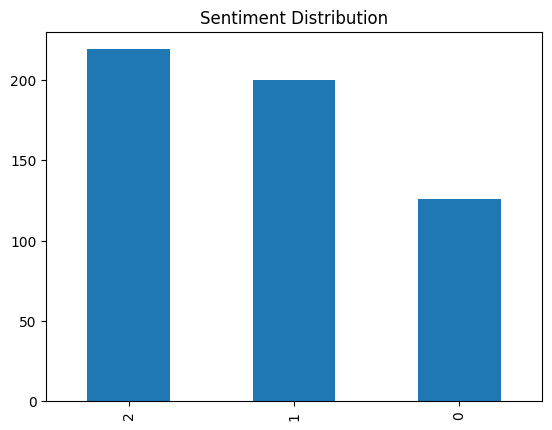

In [39]:
# @title Sentiment Distribution

processed_data['Sentiment'].value_counts().plot(kind='bar', title="Sentiment Distribution")

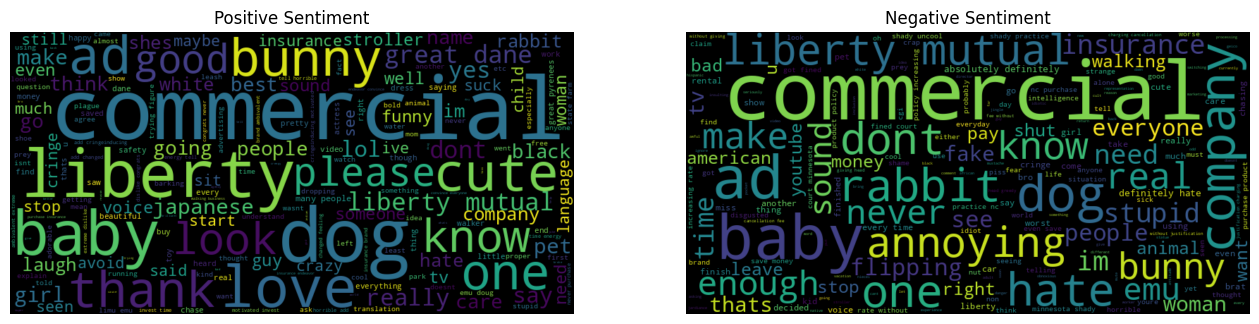

In [36]:
# @title Word Cloud for Positive and Negative Sentiment

import matplotlib.pyplot as plt
from wordcloud import WordCloud
positive_words = ' '.join(processed_data[processed_data['Sentiment'] == 2]['Sentence'].tolist())
negative_words = ' '.join(processed_data[processed_data['Sentiment'] == 0]['Sentence'].tolist())
positive_wordcloud = WordCloud(width=800, height=400).generate(positive_words)
negative_wordcloud = WordCloud(width=800, height=400).generate(negative_words)
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Sentiment')
plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
_ = plt.title('Negative Sentiment')

In [35]:
processed_data['Sentiment'].value_counts()

2    219
1    200
0    126
Name: Sentiment, dtype: int64

**Balancing data**

In [42]:
df_neutral = processed_data[(processed_data['Sentiment']==1)]
df_negative = processed_data[(processed_data['Sentiment']==0)]
df_positive = processed_data[(processed_data['Sentiment']==2)]

# upsample minority classes
df_negative_upsampled = resample(df_negative,
                                 replace=True,
                                 n_samples= 219,
                                 random_state=42)

df_neutral_upsampled = resample(df_neutral,
                                 replace=True,
                                 n_samples= 219,
                                 random_state=42)


# Concatenate the upsampled dataframes with the neutral dataframe
final_data = pd.concat([df_negative_upsampled,df_neutral_upsampled,df_positive])

In [43]:
final_data['Sentiment'].value_counts()

0    219
1    219
2    219
Name: Sentiment, dtype: int64

In [44]:
corpus = []
for sentence in final_data['Sentence']:
    corpus.append(sentence)
corpus[0:5]

['bunny damn boardwalk make sense',
 'baby first corporate brainwashing',
 'someone commented wasnt real cgi im glad pointed commercial always make anxious sad',
 'frigging hate ad',
 'know right start dog walking business make money saved enough money insurance start one']

In [46]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=1500)
X = cv.fit_transform(corpus).toarray()
y = final_data.iloc[:, -1].values

In [47]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

**Machine Learning Model**

In [48]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

**Evaluation**

In [49]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[56,  2,  4],
       [ 8, 57,  5],
       [26,  7, 33]])

In [50]:
nb_score = accuracy_score(y_test, y_pred)
print('accuracy',nb_score)

accuracy 0.7373737373737373
